# Architectural Tradeoff Analysis (PCA)

In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from paretoset import paretoset
import plotly.express as px
from adjustText import adjust_text
from pcatools import *
from tabulate import tabulate
import os
from sklearn.decomposition import PCA
from sklearn import preprocessing
import math

In [2]:
path = "C:/Users/KOQVIST1/architectural-tradeoff-analysis/Simulation data/"
filedir = "April13/combined.csv"
df = pd.DataFrame(pd.read_csv((path+filedir)))

full_length = len(df)

# Clean data by dropping inf values (and NaN)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df.drop_duplicates()

cleaned_length = len(df)

number_of_topologies = len([x for x in df.columns if x[0].isdigit()])

## Data Display

### Filtering data per Topology

In [3]:
topologies           =    [1.1, 1.2, 1.3, 1.4, 2.1, 2.2, 3.0]
latency_uplims       =    [None,None,None,None,None,None,None]
latency_lowlims      =    [None,None,None,None,None,None,None]
cost_uplims          =    [50,50,50,50,50,50,50]
cost_lowlims         =    [None,None,None,None,None,None,None]
complexity_uplims    =    [None,None,None,None,None,None,None]
complexity_lowlims   =    [None,None,None,None,None,None,None]
scalability_uplims   =    [None,None,None,None,None,None,None]
scalability_lowlims  =    [None,None,None,None,None,None,None]

df_filtered = filterData(df, topologies,latency_uplims,latency_lowlims,cost_uplims,cost_lowlims,
                        complexity_uplims,complexity_lowlims,scalability_uplims,scalability_lowlims)

for i, topo in enumerate(topologies) :
    topo_filter = df_filtered.Topology == topo
    df_filtered_topo = df_filtered[topo_filter].reset_index(drop=True)
    #if (len(df_filtered_topo)) > 0 :
        #topoScatterPrint(df_filtered_topo, 'latency','cost', False)
        #topoScatterPrint(df_filtered_topo, 'latency','scalability', False)
        #topoScatterPrint(df_filtered_topo, 'latency','complexity', False)
        #topoScatterPrint(df_filtered_topo, 'scalability','cost', False)
        #topoScatterPrint(df_filtered_topo, 'scalability','complexity', False)
        #topoScatterPrint(df_filtered_topo, 'complexity','cost', False)

Filtered out 1012 rows of data


### Optimizing Data for all topologies

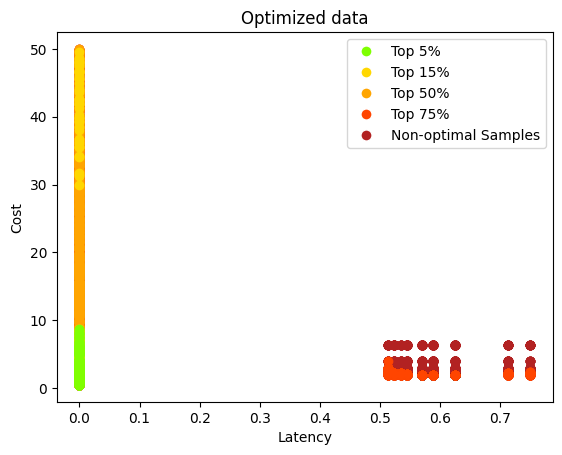

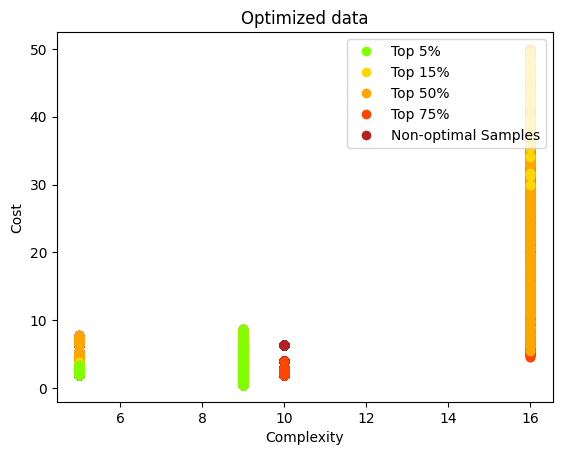

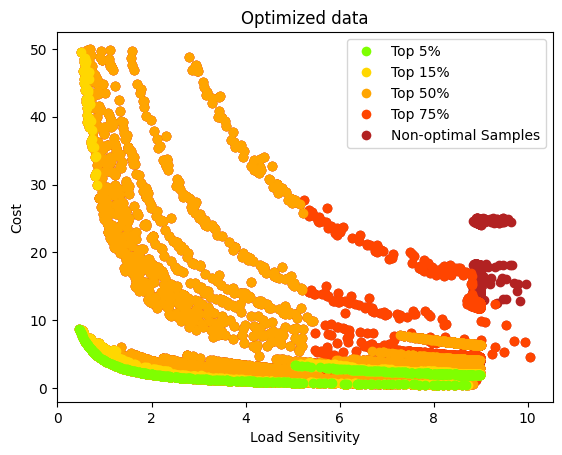

In [4]:
pareto_targets = ['latency', 'cost','complexity','scalability']
pareto_objectives = ["min", "min","min","min"]
df_opt_5 = paretoOptimize(df_filtered,pareto_targets, pareto_objectives,0.05)
df_opt_15 = paretoOptimize(df_filtered,pareto_targets, pareto_objectives,0.15)
df_opt_50 = paretoOptimize(df_filtered,pareto_targets, pareto_objectives,0.5)
df_opt_75 = paretoOptimize(df_filtered,pareto_targets, pareto_objectives,0.75)

printParetoOpt(df_filtered, df_opt_5, df_opt_15, df_opt_50, df_opt_75, False, "Optimized data")


### Optimising data for each topology individually

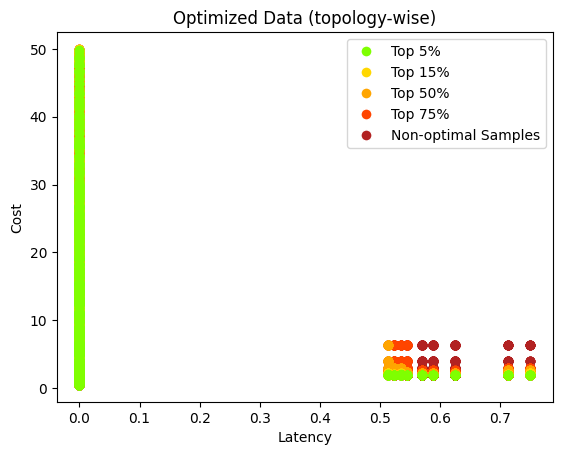

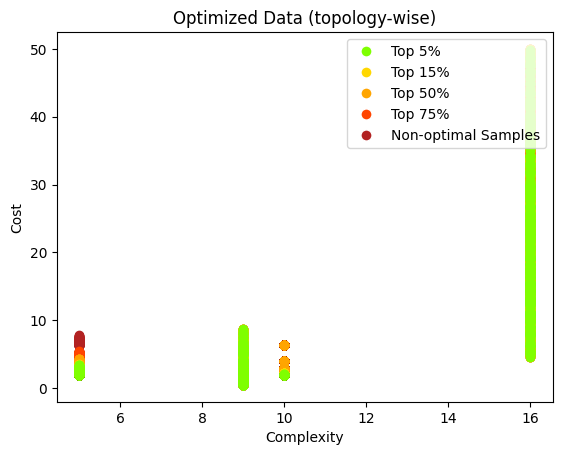

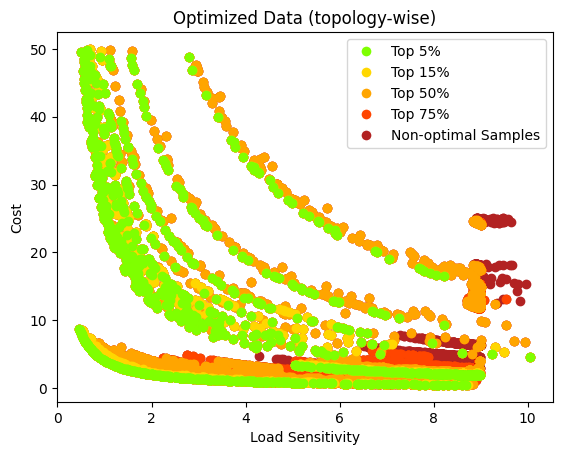

In [5]:
pareto_targets = ['latency', 'cost','complexity','scalability']
pareto_objectives = ["min", "min","min","min"]

df_t_opt_5 = pd.DataFrame()
df_t_opt_15 = pd.DataFrame()
df_t_opt_50 = pd.DataFrame()
df_t_opt_75 = pd.DataFrame()
for i, topo in enumerate(topologies) :
    topo_filter = df_filtered.Topology == topo
    df_temp_5 = paretoOptimize(df_filtered[topo_filter],pareto_targets, pareto_objectives,0.05)
    df_temp_15 = paretoOptimize(df_filtered[topo_filter],pareto_targets, pareto_objectives,0.15)
    df_temp_50 = paretoOptimize(df_filtered[topo_filter],pareto_targets, pareto_objectives,0.5)
    df_temp_75 = paretoOptimize(df_filtered[topo_filter],pareto_targets, pareto_objectives,0.75)
    df_t_opt_5 = pd.concat([df_t_opt_5,df_temp_5])
    df_t_opt_15 = pd.concat([df_t_opt_15,df_temp_15])
    df_t_opt_50 = pd.concat([df_t_opt_50,df_temp_50])
    df_t_opt_75 = pd.concat([df_t_opt_75,df_temp_75])
    

printParetoOpt(df_filtered, df_t_opt_5, df_t_opt_15, df_t_opt_50, df_t_opt_75, False, "Optimized Data (topology-wise)")


# 1: Choosing Topology

### Radar Plots

           latency      cost  complexity  load sensitivity
Topology                                                  
1.1       1.000000  0.793744         1.0          5.126629
1.2       1.000025  0.940928         1.0          4.790933
1.3       1.000000  1.007332         2.6          3.274647
1.4       1.000026  0.847576         2.6          3.342967
2.1       1.000000  3.365595         5.4          3.054484
2.2       1.007114  3.444665         5.4          3.163749
3.0       4.776556  0.733685         3.0          5.246591


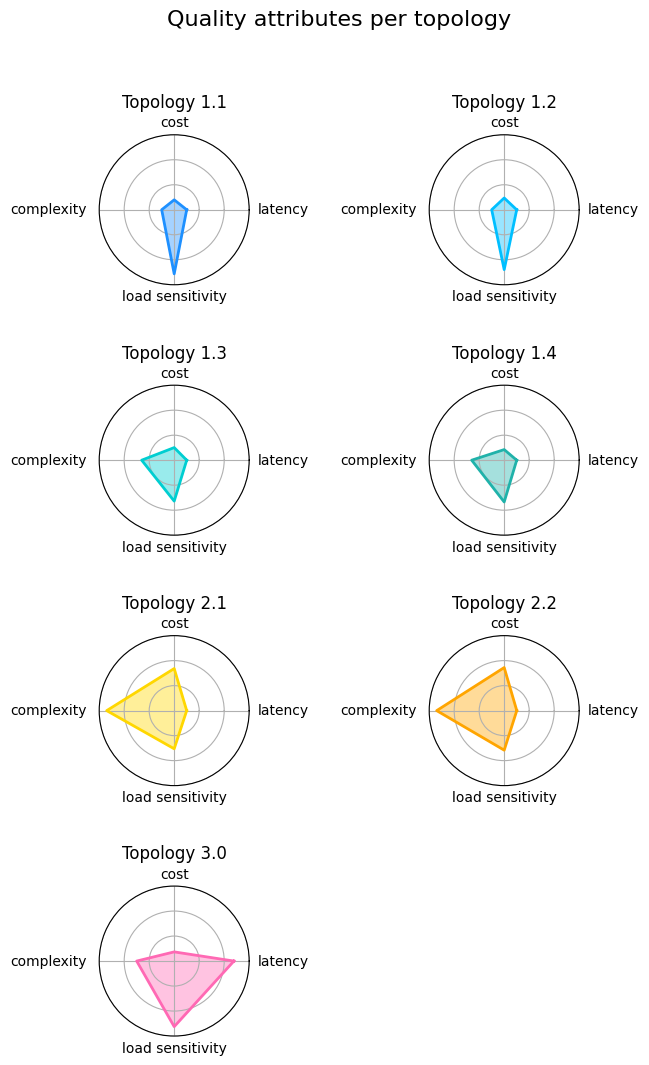

In [9]:
df_ef = df_t_opt_15
topologies = df_ef['Topology'].unique()
df_mean = pd.DataFrame()

df_mean = df_ef.groupby("Topology")[['latency','cost','complexity','scalability']].mean()

#df_mean['complexity'] = np.log(df_mean['complexity']).multiply(1)
df_mean['complexity'] = df_mean['complexity'].multiply(0.4).add(-1)
df_mean['scalability']=(df_mean['scalability']-df_mean['scalability'].mean())/df_mean['scalability'].std()
df_mean['scalability'] = df_mean['scalability'].add(4)
df_mean['cost'] = np.log10(df_mean['cost']).multiply(2.5)
df_mean['latency'] = df_mean['latency'].multiply(100000).add(10)
df_mean['latency'] = np.log10(df_mean['latency'])

df_mean.rename(columns = {'scalability':'load sensitivity'}, inplace = True)

print(df_mean)

fill_color = ["dodgerblue","deepskyblue","darkturquoise","lightseagreen", "gold", "orange","hotpink"];
"""printRadarPlots(df_mean.iloc[0:4], fill_color[0:4], 1 , 4, (-0.2,0.1,-0.42,0.1),(12,12))
printRadarPlots(df_mean.iloc[4:6], fill_color[4:6], 1 , 2, (-0.2,0.1,-0.42,0.1),(5.2,4))
printRadarPlots(df_mean.iloc[6:7], fill_color[6:7], 1 , 1, (-0.2,0.1,-0.42,0.1),(2,1.6))"""

printRadarPlots(df_mean, fill_color, 4 , 2, (-0.2,0.1,-0.42,0.1),(6,12), "Quality attributes per topology")

### PCA Analysis

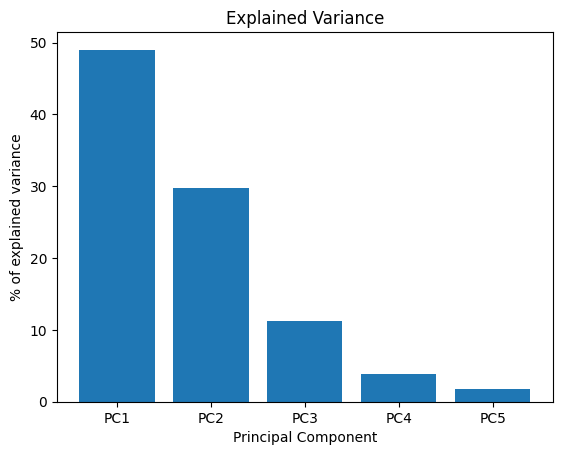

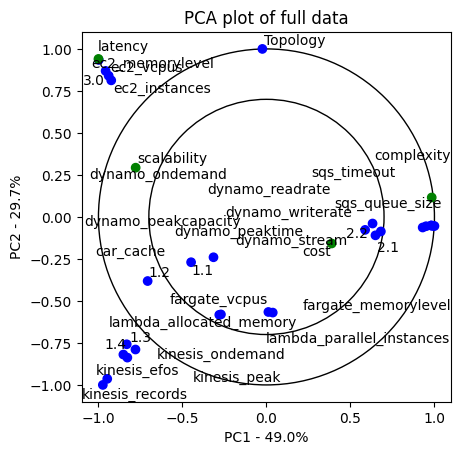

In [7]:
# Same for full matrix (without pareto)
corr_full = df.corr()
corr_full = corr_full.fillna(0)

# assign categories
buckets = [0] * len(df.columns)
buckets[-4:] = [1, 1, 1, 1]
categories = np.array(buckets)
 
# use colormap
colormap = np.array(['b', 'g'])
pca, pca_data = createPCA(corr_full)
printScree(pca, 'Explained Variance')
printPCA(pca, pca_data, corr_full, 'PCA plot of full data',categories=categories, colormap=colormap)

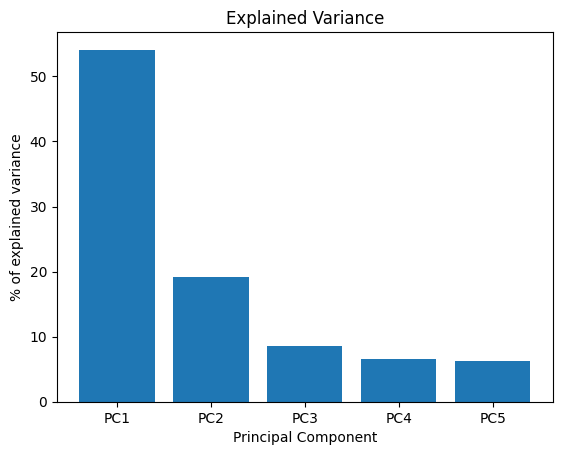

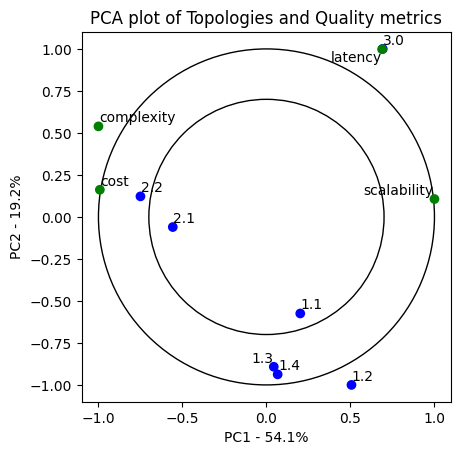

In [8]:
desired_cols = ['1.1', '1.2', '1.3', '1.4', '2.1', '2.2', '3.0','latency','cost','complexity','scalability']
df_topo = df_t_opt_15[desired_cols]

corr_topo = scaleData(df_topo).corr()
corr_topo = corr_topo.fillna(0)

# assign categories
buckets = [0] * len(df_topo.columns)
buckets[-4:] = [1, 1, 1,1]
categories = np.array(buckets)

pca, pca_data = createPCA(corr_topo)
printScree(pca, 'Explained Variance')
printPCA(pca, pca_data, corr_topo, 'PCA plot of Topologies and Quality metrics',categories=categories, colormap=colormap)